# **Мастерская Yandex.Практикум. Проект: Предсказание вероятности покупки.**

### Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель:**  
Предсказать вероятность покупки в течение 90 дней.    

**Ход решения:**
1. Загрузка и изучение данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Генерация новых признаков
5. Корреляционный анализ
6. Обучение моделей
7. Оценка и интерпретация
8. Выводы и рекомендации

## **Импорт библиотек**

In [1]:
!pip install phik -q
!pip install --upgrade scipy scikit-learn jupyter -q
!pip install shap -q
!pip install imbalanced-learn lightgbm -q

In [2]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
import os

from scipy.stats import mode
from functools import reduce
from phik import phik_matrix

from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"

In [3]:
# показывать все колонки датафреймов
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
RANDOM_STATE = 42

## **Добавление функций**

In [4]:
# функция для вывода общей информации о датафрейме
def df_review(df):
    display(df.head())
    df.info()
    display(df.describe())

In [5]:
def multi_missing_report(dfs: dict, sort: bool = True) -> pd.DataFrame:
    """
    Возвращает таблицу с количеством пропущенных значений по каждому датафрейму и колонке.
    Если в датасете нет пропусков — добавляется строка 'Пропусков в датасете нет'.
    """
    rows = []

    for name, df in dfs.items():
        na = df.isna().sum()
        na = na[na > 0]

        if na.empty:
            rows.append({
                'dataset': name, 
                'column': '—', 
                'missing_count': 'Пропусков в датасете нет'})
        else:
            for col, count in na.items():
                rows.append({'dataset': name, 'column': col, 'missing_count': int(count)})

    result = pd.DataFrame(rows)

    if sort:
        result['__sort'] = result['missing_count'].apply(lambda x: x if isinstance(x, int) else -1)
        result = result.sort_values('__sort', ascending=False).drop(columns='__sort')

    return result.reset_index(drop=True)

In [6]:
def multi_duplicates_report(dfs: dict, sort: bool = True) -> pd.DataFrame:
    """
    Возвращает таблицу с количеством и процентом дубликатов по каждому датафрейму.
    Если в датасете нет дубликатов — добавляется строка 'Дубликатов в датасете нет'.
    """
    rows = []

    for name, df in dfs.items():
        total = len(df)
        dup_count = df.duplicated().sum()

        if dup_count == 0:
            rows.append({
                'dataset': name,
                'duplicate_count': 'Дубликатов в датасете нет',
                'duplicate_pct': '-'
            })
        else:
            pct = round(dup_count / total * 100, 2)
            rows.append({
                'dataset': name,
                'duplicate_count': int(dup_count),
                'duplicate_pct': f"{pct} %"
            })

    result = pd.DataFrame(rows)

    if sort:
        result['__sort'] = result['duplicate_count'].apply(lambda x: x if isinstance(x, int) else -1)
        result = result.sort_values('__sort', ascending=False).drop(columns='__sort')

    return result.reset_index(drop=True)

In [7]:

def to_int_list(val):
    try:
        parsed = ast.literal_eval(val) if isinstance(val, str) else val
        if not parsed:  # пустой список или None
            return [-1]
        return [int(x) for x in parsed]
    except (ValueError, SyntaxError, TypeError):
        return [-1]

In [8]:
def cat_unique (dfs: dict, max_values: int = 10) -> pd.DataFrame:
    """
    Возвращает DataFrame с количеством и примером уникальных значений
    для всех категориальных колонок из словаря датафреймов.

    Parameters:
    - dfs: dict[str, pd.DataFrame] — словарь вида {'name': dataframe}
    - max_values: int — сколько уникальных значений показывать максимум

    Returns:
    - pd.DataFrame с колонками: ['dataset', 'column', 'unique_count', 'unique_values']
    """
    rows = []

    for name, df in dfs.items():
        for col in df.columns:
            if df[col].dtype.name in ['object', 'category', 'bool', 'string']:
                try:
                    uniques = df[col].dropna().unique()
                    count = len(uniques)
                    preview = list(uniques[:max_values])
                    if count > max_values:
                        preview.append('...')
                    rows.append({
                        'dataset': name,
                        'column': col,
                        'unique_count': count,
                        'unique_values': preview
                    })
                except TypeError:
                    # колонки с нехэшируемыми значениями (например, списки) пропускаем
                    continue

    return pd.DataFrame(rows).sort_values(['dataset', 'unique_count'], ascending=[True, False]).reset_index(drop=True)

## **Загрузка данных**

In [9]:
# импорт полученных для анализа датафреймов
purchases = pd.read_csv('apparel-purchases.csv', sep=',')
messages = pd.read_csv('apparel-messages.csv', sep=',')
target = pd.read_csv('apparel-target_binary.csv', sep=',')
event = pd.read_csv('full_campaign_daily_event.csv', sep=',')
event_ch = pd.read_csv('full_campaign_daily_event_channel.csv', sep=',')

In [10]:
dfs = {
    'purchases' : purchases,
    'messages'  : messages,
    'target'    : target,
    'events'    : event,
    'events_ch' : event_ch
}

### Описание данных:

**`purchases`** - история покупок

- `client_id` - идентификатор пользователя
- `quantity` - количество товаров в заказе
- `price` - цена товара
- `category_ids` - вложенные категории, к которым отнсится товар
- `date` - дата покупки
- `message_id` - идентификатор сообщения из рассылки

**`messages`** - история рекламных рассылок

- `bulk_camaign_id` - идентификатор рекламной кампании
- `client_id` - идентификатор пользователя
- `message_id` - идентификатор сообщений
- `event` - тип действия
- `channel` - канал рассылки
- `date` - дата рассылки
- `created_at` - точное время создания сообщения

**`target`** - совершит ли клиент покупку в течение следующих 90 дней

- `client_id` - идентификатор пользователя
- `target` - целевой признак

**`event`** - агрегация общей базы рассылок по дням и типам событий

- `date` - дата
- `bulk_campaign_id` - идентификатор рассылки
- `count_event` - общее количество каждого события `event`
- `nunique_event` - количество уникальных `client_id` в каждом событии

**`event_ch`** - агрегация по дням с учетом событий и каналов рассылки

- `date` - дата
- `bulk_campaign_id` - идентификатор рассылки
- `count_event_channel` - общее количество каждого события по каналам
- `nunique_event_channel` - количество уникальных `client_id` по событиям и каналам

In [11]:
df_review(purchases)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459514e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


In [12]:
df_review(messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,3.265518e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


In [13]:
df_review(target)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


In [14]:
df_review(event)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,6.362679,74.276016,0.921326,77.398689,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
std,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,79.172069,1004.271405,29.715170,1913.395511,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,9089.000000,75899.000000,5043.000000,287341.000000,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000


In [15]:
df_review(event_ch)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,31.396263,42.879753,4.116615e+02,3.271339e+03,0.287712,0.177391,24.262146,0.134125,5.960602,59.483444,7.444562e+03,58.863007,7.350267e+03,18.989990,0.810364,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,562.883309,833.316257,9.519713e+03,6.188001e+04,6.484979,2.971908,724.270910,1.976439,73.284148,1371.955350,1.393509e+05,1357.271261,1.355799e+05,1402.414107,183.298579,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,45718.000000,75899.000000,2.548617e+06,2.922440e+06,779.000000,359.000000,76281.000000,177.000000,8299.000000,165526.000000,1.154351e+07,165526.000000,6.636578e+06,287404.000000,63920.000000,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000


## **Выводы по этапу загрузки данных**

Датасет `purchases` содержит 202 208 строк и разделён на 6 столбцов. В нём содержится вся информация об истории покупок каждого покупателя, одна строка - одна позиция заказа. В столбце `price` указана цена за 1 шт. Возможно, имеет смысл создать новый столбец с общей стоимостью по заказу.  

Датасет `messages` содержит 12 739 798 строк и разделён на 7 столбцов. Он содержит информацию о рассылках и ивентах для них.     

Датасет `target` содержит 49 849 строк, разделён на 2 столбца: идентификатор пользователя и бинарный признак `target` с информацией о том, совершит ли пользователь покупку в течение следующих 90 дней (1) или нет (0).

Датасет `event` содержит 131 072 строки, раздёлен на 24 столбца. Содержит информацию о рассылках по дням и типам событий.

Датасет `event_ch` также содержит 131 072 строки, но разделён уже на 36 столбцов, так как включает ещё информацию о каналах рассылки.

<a name='2'></a>

## **Предобработка данных**

### Работа с пропущенными значениями

Проверим данные на наличие пропусков.

In [16]:
multi_missing_report(dfs)

,dataset,column,missing_count
0,purchases,—,Пропусков в датасете нет
1,messages,—,Пропусков в датасете нет
2,target,—,Пропусков в датасете нет
3,events,—,Пропусков в датасете нет
4,events_ch,—,Пропусков в датасете нет


Пропуски отсутствуют.

### Работа с дубликатами

#### Явные дубликаты

Посмотрим сначала на явные дубликаты.

In [17]:
multi_duplicates_report(dfs)

,dataset,duplicate_count,duplicate_pct
0,purchases,73020,36.11 %
1,messages,48610,0.38 %
2,target,Дубликатов в датасете нет,-
3,events,Дубликатов в датасете нет,-
4,events_ch,Дубликатов в датасете нет,-


Количество дубликатов в датасете `purchases` составляет 36.11%. Они могли возникнуть, например, по причине того, что заказ на несколько единиц товара записывается отдельными строками. 

В датасете `messages` всего 0.38% дубликатов. Посмотрим на них.

In [18]:
messages[messages.duplicated(keep=False)]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
966465,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
966466,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
967281,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56
...,...,...,...,...,...,...,...
12739720,14600,1515915625468103375,1515915625468103375-14600-65c2038646d16,click,mobile_push,2024-02-15,2024-02-15 21:52:00
12739721,14607,1515915625468103375,1515915625468103375-14607-65c33b1f402bb,click,mobile_push,2024-02-15,2024-02-15 21:52:00
12739722,14607,1515915625468103375,1515915625468103375-14607-65c33b1f402bb,click,mobile_push,2024-02-15,2024-02-15 21:52:00
12739730,14623,1515915625559065669,1515915625559065669-14623-65c5c5df06b3b,click,mobile_push,2024-02-15,2024-02-15 22:02:19


In [19]:
messages[messages.duplicated(keep=False)]['event'].value_counts()

event
open           65402
click          25204
purchase        3595
hard_bounce      257
send              44
unsubscribe       13
complain           2
soft_bounce        2
Name: count, dtype: int64

Скорее всего, если дубликаты полные и они встречаются в разных ивентах, то это говорит об ошибке хранения или импорта данных, а не о пользовательском поведении. Например, один и тот же файл логов подтянулся дважды. Можем спокойно удалить эти строки, так как они составляют даже меньше 1% датасета.

In [20]:
messages = messages.drop_duplicates()

#### Неявные дубликаты

Перед обработкой неявных дубликатов преобразуем значения столбца `category_ids`в датасете `purchases` в списки с целочисленными значениями.

In [21]:
purchases['category_ids'] = purchases['category_ids'].apply(to_int_list)

In [22]:
purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id
188362,1515915625584180028,1,350.0,"[5562, 5536, 5544, 854]",2023-12-26,1515915625584180028-14391-658a9ca463d06
37537,1515915625491155033,1,1799.0,"[5562, 5630, 5669, 668]",2022-09-08,1515915625491155033-6336-63198505a127f
89953,1515915625491634192,1,699.0,"[4, 28, 49, 413]",2023-03-07,1515915625491634192-10671-6405d24a3787d
157449,1515915625489731554,1,2060.0,"[4, 31, 329, 506]",2023-07-12,1515915625489731554-13471-64abf24d0840c
56612,1515915625572508643,1,1.0,"[4, 27, 138, 468]",2022-11-15,1515915625572508643-7845-6373358428e1d


In [23]:
cat_unique(dfs)

,dataset,column,unique_count,unique_values
0,events,date,727,"[2022-05-19, 2022-05-20, 2022-05-21, 2022-05-2..."
1,events_ch,date,727,"[2022-05-19, 2022-05-20, 2022-05-21, 2022-05-2..."
2,messages,message_id,9061667,"[1515915625626736623-4439-6283415ac07ea, 15159..."
3,messages,created_at,4103539,"[2022-05-19 00:14:20, 2022-05-19 00:39:34, 202..."
4,messages,date,638,"[2022-05-19, 2022-05-20, 2022-05-21, 2022-05-2..."
5,messages,event,11,"[open, click, purchase, send, unsubscribe, hbq..."
6,messages,channel,2,"[email, mobile_push]"
7,purchases,message_id,50204,"[1515915625468169594-4301-627b661e9736d, 15159..."
8,purchases,date,642,"[2022-05-16, 2022-05-17, 2022-05-18, 2022-05-1..."


In [24]:
messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

Добавим в датасет `purchases` категории первого (основной класс) и последнего уровня (конкретный подтип), которые мы выделим из `category_ids`.

In [25]:
purchases['first_cat'] = purchases['category_ids'].apply(lambda x: x[0])
purchases['last_cat'] = purchases['category_ids'].apply(lambda x: x[-1])

purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id,first_cat,last_cat
3473,1515915625474319290,1,1999.0,"[4, 28, 124, 415]",2022-05-26,1515915625474319290-4568-628ddb5e63e53,4,415
187681,1515915625752558835,1,99.0,"[4, 28, 290, 424]",2023-12-25,1515915625752558835-14359-6587f2eb2bedb,4,424
188788,1515915626005650227,1,35.0,"[4, 1822, 38, 479]",2023-12-26,1515915626005650227-14342-65815120687da,4,479
175207,1515915625552965648,1,30.0,"[4, 44, 491]",2023-11-03,1515915625552965648-14052-6544b2013726e,4,491
70337,1515915625558549238,1,2999.0,"[5562, 5589, 5605, 1710]",2022-12-20,1515915625558549238-8813-63a1acfb41cf7,5562,1710


## **Выводы по этапу предобработки данных**

1. Пропуски в данных отсутствуют.
2. Количество дубликатов в датасете `purchases` - 36.11%. Они могут иметь объяснение, например, система записывала несколько товаров отдельными строками, поэтому оставим их. Тем более число довольно большое для удаления. 
3. 0.38% дубликатов имеет датасет `messages`. Удалили их.
4. Преобразовали `category_ids` в списки с целочисленными значениями. Выделили на его основе категории первого и последнего уровней.
5. Неявных дубликатов не обнаружено. В датасете `messages` есть всего два канала рассылки: имейл и мобильное пуш-уведомление. В этом же датафрейме существует 11 типов ивентов:
- `send` - сообщение успешно отправлено пользователю.
- `open` - пользователь открыл письмо.
- `click` - пользователь кликнул по ссылке внутри письма.
- `purchase` - пользователь совершил покупку после перехода из письма
- `hard_bounce` - письмо не доставлено по жёсткой причине — несуществующий адрес, блокировка домена и т.п.
- `soft_bounce` - временная ошибка доставки — например, переполнен ящик, сервер недоступен.
- `unsubscribe` - пользователь отписался от рассылки.
- `hbq_spam` - пользователь или провайдер пометил письмо как спам.
- `complain` - пользователь нажал "пожаловаться на спам"
- `subscribe` - пользователь подписался на рассылку
- `close` - пользователь закрыл письмо

## **Исследовательский анализ данных**

### **`purchases`**

In [26]:
df_review(purchases)

,client_id,quantity,price,category_ids,date,message_id,first_cat,last_cat
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,431
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,432
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,413


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
 6   first_cat     202208 non-null  int64  
 7   last_cat      202208 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 12.3+ MB


,client_id,quantity,price,first_cat,last_cat
count,2.022080e+05,202208.000000,202208.000000,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516,1545.858873,889.143021
std,1.459514e+08,0.184384,1342.252664,2514.473457,1065.663389
min,1.515916e+18,1.000000,1.000000,-1.000000,-1.000000
25%,1.515916e+18,1.000000,352.000000,4.000000,432.000000
50%,1.515916e+18,1.000000,987.000000,4.000000,555.000000
75%,1.515916e+18,1.000000,1699.000000,5562.000000,765.000000
max,1.515916e+18,30.000000,85499.000000,6060.000000,6323.000000


Посмотрим на количественные признаки датасета `purchase`. Это `quantity` и `price`. Первый признак дискретный, поэтому его, возможно, даже стоит рассматривать как категориальный. 

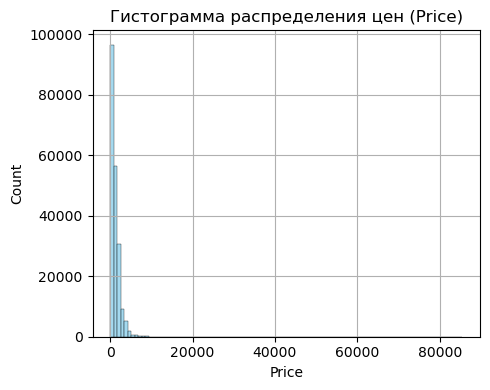

In [27]:
plt.figure(figsize=(5, 4))
sns.histplot(
    data=purchases,
    x='price',
    bins=100,
    kde=False,
    color='skyblue',
    edgecolor='black'
)

plt.title('Гистограмма распределения цен (Price)')
plt.xlabel('Price')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

Распределение сильно смещенно вправо, то есть это признак положительных выбросов (много очень дорогих товаров). Сделаем логарифмирование этого признака.

In [28]:
purchases['log_price'] = np.log1p(purchases['price'])

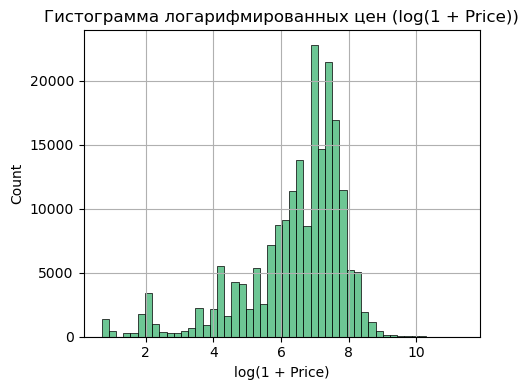

In [29]:
plt.figure(figsize=(5, 4))
sns.histplot(data=purchases, x='log_price', bins=50, color='mediumseagreen', edgecolor='black')
plt.title('Гистограмма логарифмированных цен (log(1 + Price))')
plt.xlabel('log(1 + Price)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

После логарифмирования получаем распределение, близкое к нормальному, с немного удлиненным хвостом слева в зоне недорогих товаров.

Оценим крайние значения. Для этого посмотрим на количество товаров стоимостью ниже 5 и больше 10 000.

In [30]:
print('< 5 Количество ', (purchases['price'] < 5).sum(), ', доля', (purchases['price'] < 5).mean())

print('> 10000 Количество ', (purchases['price'] > 10000).sum(), ', доля', (purchases['price'] > 10000).mean())

< 5 Количество  2325 , доля 0.011498061402120589
> 10000 Количество  332 , доля 0.0016418737141952841


Т.к. доля таких товаров едва превышает 1%, удалим эти товары как выбросы в данных.

In [31]:
purchases = purchases[(purchases['price'] > 5) & (purchases['price'] < 10000)]


Рассмотрим признак `quantity`.

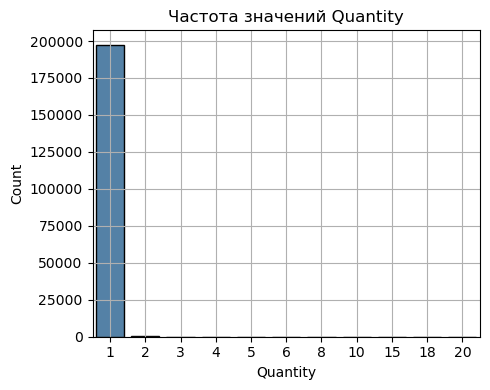

In [32]:
plt.figure(figsize=(5, 4))
sns.countplot(
    data=purchases,
    x='quantity',
    color='steelblue',
    edgecolor='black'
)

plt.title('Частота значений Quantity')
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

Большинство товаров имеет количество 1, что подтверждает предположение об особенностях работы системы.

Посмотрим на количество товаров в агрегации по заказам.

In [33]:
agg_quantity = (
    purchases
    .groupby(['client_id', 'date', 'first_cat', 'last_cat'])['quantity']
    .sum()
    .reset_index()
    .rename(columns={'quantity': 'total_quantity'})
)

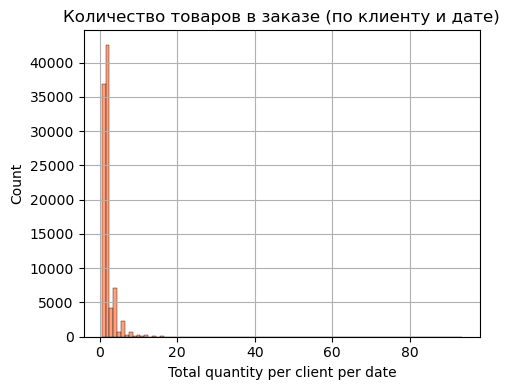

In [34]:
plt.figure(figsize=(5, 4))
sns.histplot(agg_quantity['total_quantity'], bins=20, discrete=True, color='coral', edgecolor='black')

plt.title('Количество товаров в заказе (по клиенту и дате)')
plt.xlabel('Total quantity per client per date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
agg_quantity.sort_values('total_quantity', ascending=False).head(10)

,client_id,date,first_cat,last_cat,total_quantity
71427,1515915625624308268,2022-11-11,5562,572,93
6137,1515915625470883759,2022-11-04,5562,572,75
73163,1515915625634092896,2023-11-16,2,445,55
36530,1515915625500440898,2023-08-31,5562,889,51
597,1515915625468080545,2023-04-29,5562,1173,50
51172,1515915625558905996,2022-11-13,5562,572,49
80070,1515915625765986742,2022-12-21,4,505,48
80241,1515915625766036976,2024-01-18,5562,889,40
62860,1515915625581786063,2023-04-19,4,656,38
50741,1515915625558773501,2023-08-13,5562,889,37


В большинстве случаев количество товаров в заказе не превышает 10, в редких случаях оказывается выше 20 и достигает максимума для единичных заказов в количеством товаров чуть больше 90. 

Рассмотрим временной признак `date`.

In [36]:
purchases['date'] = pd.to_datetime(purchases['date'])

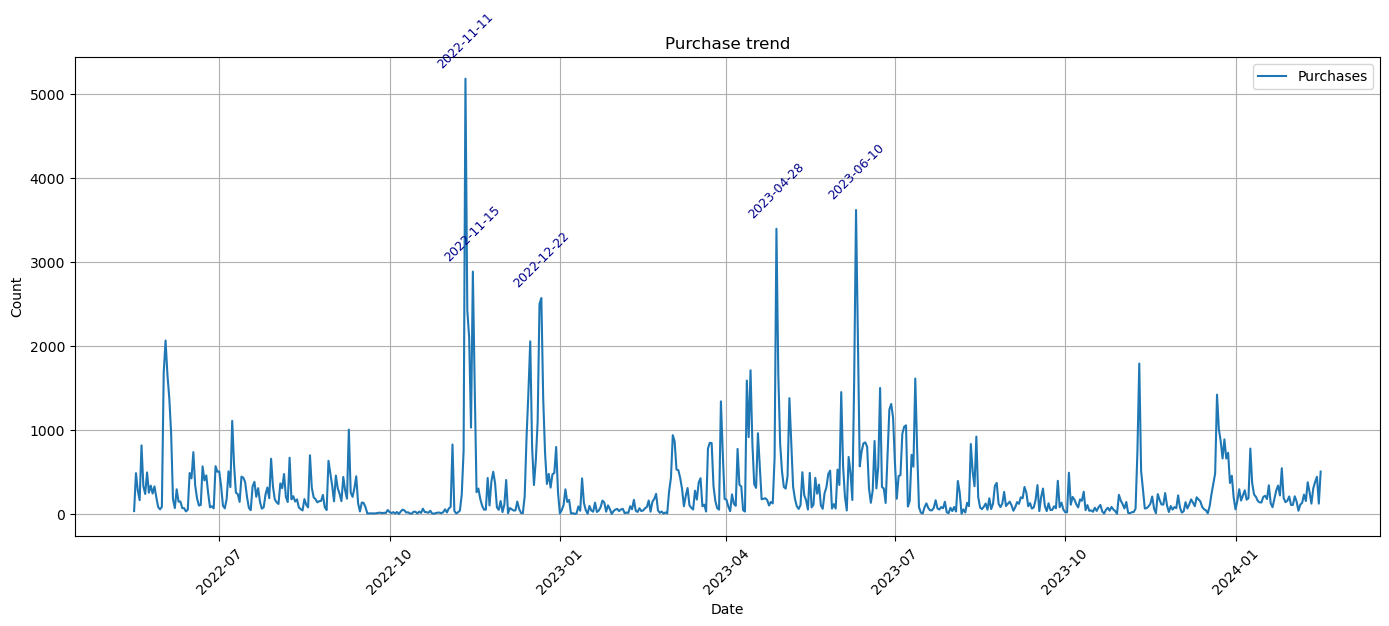

In [37]:
daily_counts = (
    purchases
    .groupby('date')
    .size()
    .reset_index(name='count')
)

top_n = 5
top_peaks = daily_counts.nlargest(top_n, 'count')

plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_counts, x='date', y='count', label='Purchases')
for _, row in top_peaks.iterrows():
    plt.text(row['date'], row['count'] + 100,  # немного выше точки
             row['date'].strftime('%Y-%m-%d'),
             ha='center', va='bottom', fontsize=9, rotation=45, color='darkblue')

plt.title('Purchase trend')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Видим, что самой пиковой датой стало 11 ноября 2022 года. Именно в этот день маркет плейсы часто устраивают главные распродажи года. Также можно заметить, что количество покупок в день в 2023 году в среднем выше, чем в другие представленные в датасете годы.

Посмотрим на признаки `first_cat` и `last_cat`.

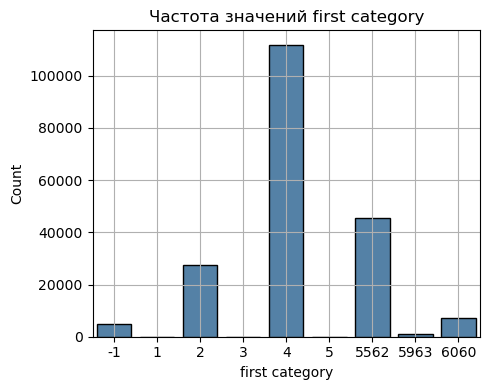

In [38]:
plt.figure(figsize=(5, 4))
sns.countplot(
    data=purchases,
    x='first_cat',
    color='steelblue',
    edgecolor='black'
)

plt.title('Частота значений first category')
plt.xlabel('first category')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

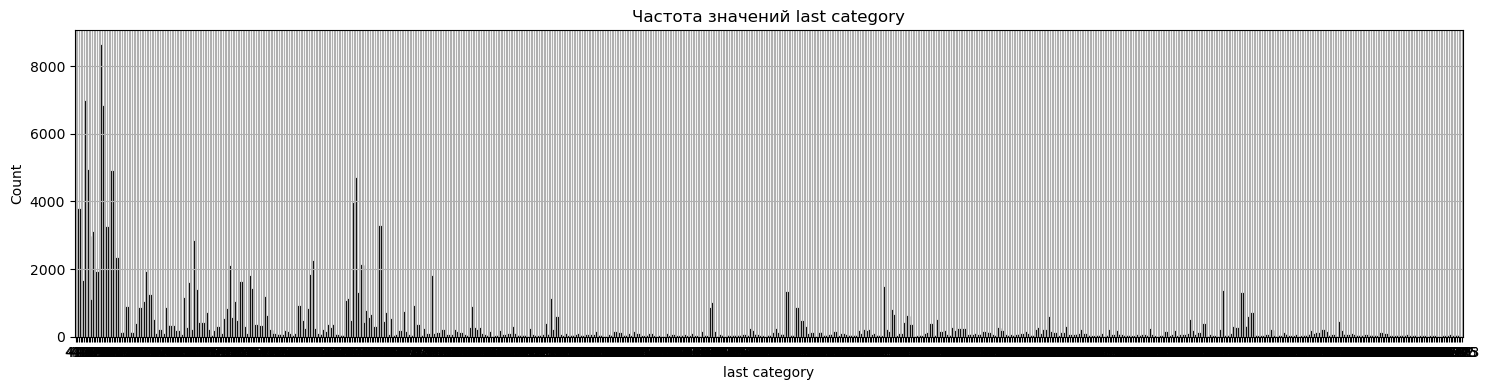

In [39]:
plt.figure(figsize=(15, 4))
sns.countplot(
    data=purchases,
    x='last_cat',
    color='steelblue',
    edgecolor='black'
)

plt.title('Частота значений last category')
plt.xlabel('last category')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

Количество уникальных значений в first category существенно ниже, чем в last category, что представляется логичным. Наибольшее количество товаров преобретено в first category 4.

**Вывод:**
- среди покупок преобладают товары с ценой, не превышающей 10 000, и не меньше 5,
- цену (признак `price`) имеет смысл перевести в логарифмический масштаб,
- большинство товаров имеет количество единиц равное 1, что в том числе говорит об особенностях работы системы,
- в большинстве случаев количество товаров в одном заказе не превышает 10, а максимальное количество товаров в заказе в данных равно 96,
- самой пиковой датой по числу покупок является 11.11.2022, что, скорее всего, совпадает с традиционной датой ноябрьяских распродаж,
- в 2023 году число покупок в день было в среднем больше, чем в другие годы,
- существует намного меньше категорий `first cat`, чем категорий `last cat`,
- большинство купленных товаров находятся в `first cat` закодированной как 4.

### **`messages`**

In [40]:
df_review(messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 774.6+ MB


,bulk_campaign_id,client_id
count,1.269119e+07,1.269119e+07
mean,1.159768e+04,1.515916e+18
std,3.262181e+03,3.250414e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


`event` и `channel` - категориальные признаки, `date` и `created_at`- временные. 

#### Категориальные признаки

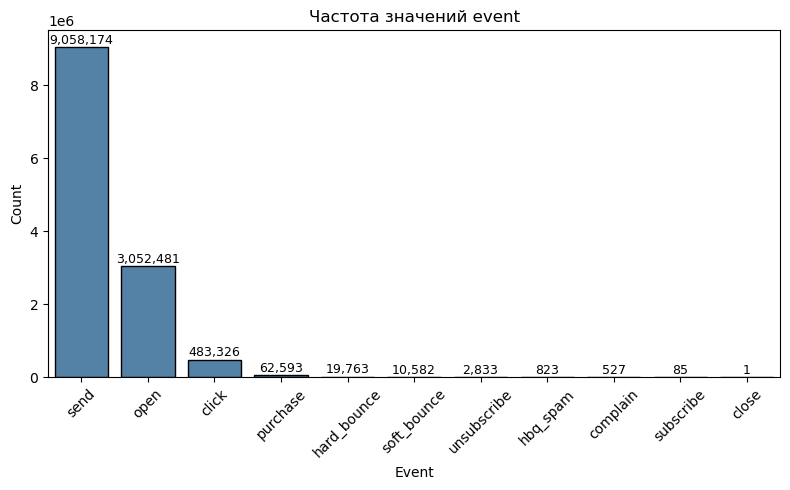

In [41]:
event_counts = messages['event'].value_counts()

# Рисуем график
plt.figure(figsize=(8, 5))
sns.barplot(x=event_counts.index, y=event_counts.values, color='steelblue', edgecolor='black')

# Добавляем подписи над столбцами
for i, v in enumerate(event_counts.values):
    plt.text(i, v + max(event_counts.values) * 0.01, f'{v:,}', ha='center', fontsize=9)

plt.title('Частота значений event')
plt.xlabel('Event')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Отправка рассылки - наиболее частое событие. Также видно, что открытие было совершено только для трети отправленных рассылок

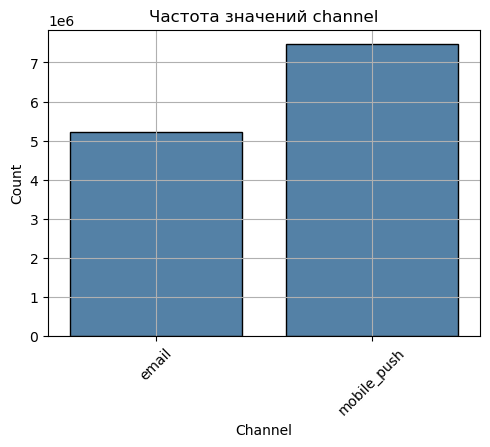

In [42]:
plt.figure(figsize=(5, 4))
sns.countplot(
    data=messages,
    x='channel',
    color='steelblue',
    edgecolor='black'
)

plt.title('Частота значений channel')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

В данных существует всего 2 канала рассылок: по email и через mobile push. Mobile push является наиболее часто используемым каналом для рассылок.

In [43]:
messages['date'] = messages['date'].astype('datetime64[ns]')

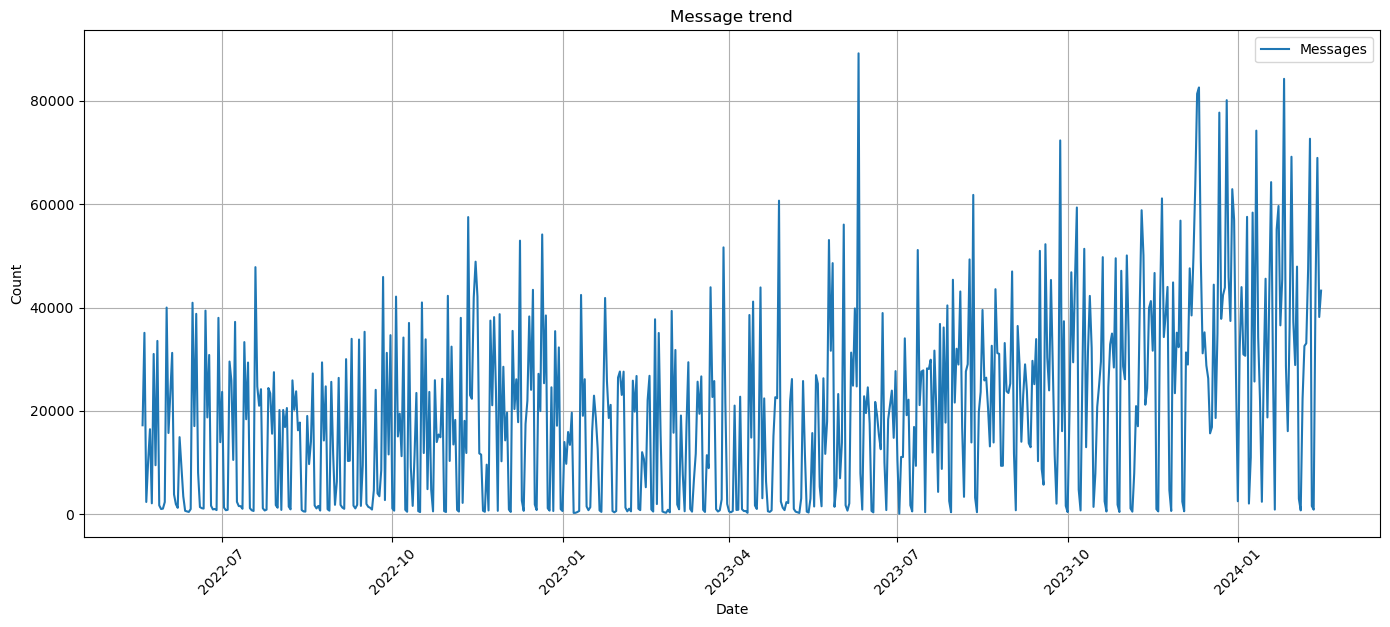

In [44]:
daily_counts = (
    messages
    .groupby('date')
    .size()
    .reset_index(name='count')
)

top_n = 5
top_peaks = daily_counts.nlargest(top_n, 'count')

plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_counts, x='date', y='count', label='Messages')

plt.title('Message trend')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Видно, что примерно с конца первого квартала 2023 года количество рассылок плавно увеличивается. Интересно, что на графике не замечена корреляция между увеличением количества рассылок и числом покупок. 
Прослеживается цикл с равными интервалами провалов, что, скорее всего, связано с тем, что рассылки не отправляются каждый день.

**Вывод:**
- отправка рассылки - наиболее частое событие в таблице,
- что открытие было совершено для менее, чем половины отправленных рассылок,
- в данных существует всего 2 канала рассылок: по email и через mobile push, где mobile push является наиболее часто используемым каналом для рассылок,
- с конца первого квартала 2023 года количество рассылок плавно увеличивается,
- на графиках не замечена корреляция между увеличением количества рассылок и числом покупок.

### **`target`**

In [45]:
df_review(target)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


Количественных и временных признаков в датафрейме нет.
Категориальные признаки:
- `target` - флаг, совершил ли полтзователь покупку в таргетный период

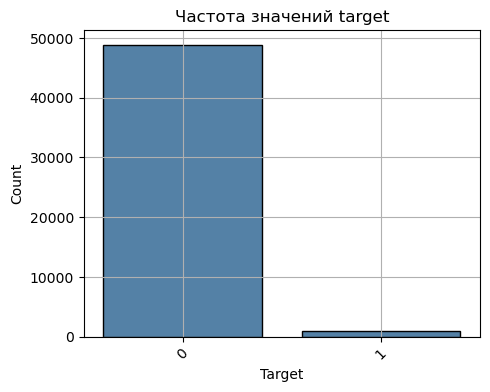

In [46]:
plt.figure(figsize=(5, 4))
sns.countplot(
    data=target,
    x='target',
    color='steelblue',
    edgecolor='black'
)

plt.title('Частота значений target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

**Вывод:**
Большинство пользователей попадает в категорию 0, то есть не совершают покупку. Это создает дисбаланс классов, который может сказаться на обучении модели. В дальнейшем стоит воспользоваться методами балансировки классов и/или использовать взвешивание классов.

### **`event`**

In [47]:
df_review(event)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,6.362679,74.276016,0.921326,77.398689,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
std,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,79.172069,1004.271405,29.715170,1913.395511,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,9089.000000,75899.000000,5043.000000,287341.000000,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000


### **`event_ch`**

In [48]:
df_review(event_ch)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,31.396263,42.879753,4.116615e+02,3.271339e+03,0.287712,0.177391,24.262146,0.134125,5.960602,59.483444,7.444562e+03,58.863007,7.350267e+03,18.989990,0.810364,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,562.883309,833.316257,9.519713e+03,6.188001e+04,6.484979,2.971908,724.270910,1.976439,73.284148,1371.955350,1.393509e+05,1357.271261,1.355799e+05,1402.414107,183.298579,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,45718.000000,75899.000000,2.548617e+06,2.922440e+06,779.000000,359.000000,76281.000000,177.000000,8299.000000,165526.000000,1.154351e+07,165526.000000,6.636578e+06,287404.000000,63920.000000,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000


**Вывод:**
Последние две таблицы: `event` и `event_channel`, не несут информации о пользователях и покупках, и поэтому не будут рассматриваться для обучения модели

## **Выводы по исследовательскому анализу данных**

На данном этапе:
- изучен харакрет распределения данных
- устранены аномальные значения признака `price`
- обнаружено отсутствие зависимости между увеличением количества рассылок и покупками
- выявлен дисбаланс классов  

## **Добавление новых признаков**

### **`purchases`**

In [49]:
purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id,first_cat,last_cat,log_price
169395,1515915625577121613,1,7699.0,"[4, 28, 249, 615]",2023-09-15,1515915625986038864-13804-6502f62e50c86,4,615,8.948976
94596,1515915625943494332,1,1355.0,"[4, 31, 324, 1431]",2023-03-23,1515915625489442922-11144-641ad2da50c90,4,1431,7.212294
46670,1515915625559316240,1,1679.0,"[4, 28, 62, 657]",2022-11-11,1515915625475985012-7803-636dfed751815,4,657,7.426549
79102,1515915625670836704,1,139.0,"[4, 27, 138, 468]",2022-12-26,1515915625792265802-8995-63a5b1431a918,4,468,4.941642
82006,1515915625590848800,1,196.0,"[5562, 5589, 5605, 1712]",2023-01-04,1515915625590848800-9197-63b40ace74499,5562,1712,5.283204


Добавим на основе признака с количеством и ценой признак с итоговой стоимостью `price_total`.

In [50]:
purchases['price_total'] = purchases['quantity'] * purchases['price']
purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id,first_cat,last_cat,log_price,price_total
10009,1515915625470683839,1,699.0,"[4, 28, 49, 413]",2022-06-04,1515915625470683839-4679-6297225663794,4,413,6.551080,699.0
68665,1515915625586727734,1,599.0,"[4, 28, 146, 548]",2022-12-17,1515915625586727734-8725-639b2f043d709,4,548,6.396930,599.0
103626,1515915625490029172,1,1221.0,"[5562, 5631, 5549, 1831]",2023-04-14,1515915625786840108-11796-643902c89cb1c,5562,1831,7.108244,1221.0
36737,1515915625638642615,1,840.0,"[2, 17, 330, 387, 467]",2022-09-05,1515915625638642615-6251-6311b134269cb,2,467,6.734592,840.0
31578,1515915625487445691,1,1499.0,"[5562, 5634, 5551, 769]",2022-08-17,1515915625487445691-6042-62fcdbd092ce7,5562,769,7.313220,1499.0


Сагрегируем информацию о сумме всех покупок для каждого пользователя за каждый день. Посмотрим на медианное значение.

In [51]:
daily_spending = purchases.pivot_table(
    index=['client_id', 'date'],
    values='price_total',
    aggfunc='sum'
).reset_index()

agg_purchase = daily_spending.pivot_table(
    index='client_id',
    values='price_total',
    aggfunc='median'
).reset_index()

agg_purchase.rename(columns={'price_total': 'median_spending'}, inplace=True)

print(agg_purchase.shape)
agg_purchase.sample(10)

(49707, 2)


,client_id,median_spending
10289,1515915625489222539,5097.0
37789,1515915625640301069,1699.0
3272,1515915625471460159,5247.0
40355,1515915625745304302,1695.0
16184,1515915625491290696,2656.0
35862,1515915625610698990,11198.0
14135,1515915625490551842,9997.0
43366,1515915625812015053,654.5
11102,1515915625489472864,999.0
1965,1515915625468217953,4398.0


Также вычислим последнюю дату покупки клиента, медиану стоимости и количества товара, а также моду для выделенных нами первой и последней категорий.

In [52]:
agg_purchase_client = purchases.groupby('client_id').agg({
    'date': 'max',
    'price': 'median',
    'quantity': 'median',
    'first_cat': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'last_cat': lambda x: x.mode().iloc[0] if not x.mode().empty else None
}).reset_index()

agg_purchase_client = agg_purchase_client.merge(agg_purchase, how='left', on='client_id')

print(agg_purchase_client.shape)
agg_purchase_client.head()

(49707, 7)


,client_id,date,price,quantity,first_cat,last_cat,median_spending
0,1515915625468060902,2022-05-27,999.0,1.0,4,420,6993.0
1,1515915625468061003,2023-01-04,2100.0,1.0,4,615,16235.0
2,1515915625468061099,2022-05-17,299.0,1.0,4,424,299.0
3,1515915625468061100,2024-02-10,1049.0,1.0,4,5717,2098.0
4,1515915625468061170,2023-06-17,2195.0,1.0,4,420,5412.0


На основе последней даты покупки выделим количество прошедших дней после последней покупки.

In [53]:
last_date = agg_purchase_client['date'].max() + pd.Timedelta(days=2)
agg_purchase_client['days_since_last_purchase'] = (last_date - agg_purchase_client['date']).dt.days

In [54]:
agg_purchase_client.rename(columns={'date': 'last_purchase_date', 'first_cat': 'first_cat_mode', 
                      'last_cat': 'last_cat_mode', 'price': 'median_price', 
                      'quantity': 'median_quantity'}, inplace=True)
agg_purchase_client.head()

,client_id,last_purchase_date,median_price,median_quantity,first_cat_mode,last_cat_mode,median_spending,days_since_last_purchase
0,1515915625468060902,2022-05-27,999.0,1.0,4,420,6993.0,632
1,1515915625468061003,2023-01-04,2100.0,1.0,4,615,16235.0,410
2,1515915625468061099,2022-05-17,299.0,1.0,4,424,299.0,642
3,1515915625468061100,2024-02-10,1049.0,1.0,4,5717,2098.0,8
4,1515915625468061170,2023-06-17,2195.0,1.0,4,420,5412.0,246


### **`messages`**

In [55]:
messages.sample(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
10837374,14391,1515915625571609013,1515915625571609013-14391-658a9c917c7f6,send,mobile_push,2023-12-26,2023-12-26 09:46:55
12328990,14587,1515915625623213312,1515915625623213312-14587-65bcc259c3df9,click,email,2024-02-02,2024-02-02 17:28:42
3402259,9111,1515915625722416586,1515915625722416586-9111-63ac56a1bd48f,send,mobile_push,2022-12-28,2022-12-28 15:52:55
1943360,7105,1515915625502919689,1515915625502919689-7105-634933391189d,send,email,2022-10-14,2022-10-14 10:55:56
10616491,14352,1515915625503485908,1515915625503485908-14352-658557c6827c9,open,mobile_push,2023-12-22,2023-12-22 10:04:58


Имеет смысл выделить категории ивентов: open, click и все остальные негативные. Посчитать их количество и определить долю от всего числа рассылок на клиента. 

In [56]:
# Категоризируем события
def categorize_event(event):
    if event in ['open', 'click', 'purchase']:
        return 'positive'
    elif event in ['unsubscribe', 'complain', 'hard_bounce', 'soft_bounce', 'hbq_spam', 'close']:
        return 'negative'
    else:
        return 'technical'

messages['event_type'] = messages['event'].apply(categorize_event)

# Считаем количество событий по типам
agg_message_client = (
    messages
    .groupby(['client_id', 'event_type'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Считаем общее количество событий
agg_message_client['total_events'] = agg_message_client[['positive', 'negative', 'technical']].sum(axis=1)

# Вычисляем доли
agg_message_client['positive_ratio'] = agg_message_client['positive'] / agg_message_client['total_events']
agg_message_client['negative_ratio'] = agg_message_client['negative'] / agg_message_client['total_events']
agg_message_client['technical_ratio'] = agg_message_client['technical'] / agg_message_client['total_events']

print(agg_message_client.shape)
agg_message_client.head()

(53329, 8)


event_type,client_id,negative,positive,technical,total_events,positive_ratio,negative_ratio,technical_ratio
0,1515915625468060902,1,50,126,177,0.282486,0.005650,0.711864
1,1515915625468061003,0,11,154,165,0.066667,0.000000,0.933333
2,1515915625468061099,2,59,215,276,0.213768,0.007246,0.778986
3,1515915625468061100,2,159,267,428,0.371495,0.004673,0.623832
4,1515915625468061170,0,50,243,293,0.170648,0.000000,0.829352


Добавим к этому количество и долю для разных каналов рассылки.

In [57]:
channel_counts = (
    messages
    .groupby(['client_id', 'channel'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

channel_cols = [col for col in channel_counts.columns if col != 'client_id']
channel_counts['total_channel_events'] = channel_counts[channel_cols].sum(axis=1)

for col in channel_cols:
    channel_counts[f'{col}_ratio'] = channel_counts[col] / channel_counts['total_channel_events']

agg_message_client_channel = pd.merge(agg_message_client, channel_counts, on='client_id', how='left')

print(agg_message_client_channel.shape)
agg_message_client_channel.head()

(53329, 13)


,client_id,negative,positive,technical,total_events,positive_ratio,negative_ratio,technical_ratio,email,mobile_push,total_channel_events,email_ratio,mobile_push_ratio
0,1515915625468060902,1,50,126,177,0.282486,0.005650,0.711864,177,0,177,1.00000,0.00000
1,1515915625468061003,0,11,154,165,0.066667,0.000000,0.933333,165,0,165,1.00000,0.00000
2,1515915625468061099,2,59,215,276,0.213768,0.007246,0.778986,182,94,276,0.65942,0.34058
3,1515915625468061100,2,159,267,428,0.371495,0.004673,0.623832,0,428,428,0.00000,1.00000
4,1515915625468061170,0,50,243,293,0.170648,0.000000,0.829352,202,91,293,0.68942,0.31058


### **Создание единого датафрейма**

Проверим размерности созданных таблиц `agg_purchase_client` и `agg_message_client_channel` и `target`.

In [58]:
print("Размер agg_purchase_client:", agg_purchase_client.shape)
print("Размер agg_message_client_channel:", agg_message_client_channel.shape)
print("Размер target:", target.shape)

Размер agg_purchase_client: (49707, 8)
Размер agg_message_client_channel: (53329, 13)
Размер target: (49849, 2)


Объединяем датасеты в `data`. Мы хотим оставить только тех клиентов, у кого есть покупки.

In [59]:
data = (
    agg_purchase_client
    .merge(agg_message_client_channel, on='client_id', how='left')
    .merge(target, on='client_id', how='left')
)

print("Размер объединённого датафрейма:", data.shape)

Размер объединённого датафрейма: (49707, 21)


Проверим получившийся датасет `data` на наличие пропусков.

In [60]:
missing = data.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if missing.empty:
    print("❗️Пропущенных значений нет.")
else:
    print("🧼 Пропущенные значения:")
    print(missing)

🧼 Пропущенные значения:
negative                7847
positive                7847
technical               7847
total_events            7847
positive_ratio          7847
negative_ratio          7847
technical_ratio         7847
email                   7847
mobile_push             7847
total_channel_events    7847
email_ratio             7847
mobile_push_ratio       7847
dtype: int64


Возникли пропуски, так как не о всех пользователях есть информация в датасете `messages`. Заполним их значением -1.

In [61]:
data = data.fillna(-1)
df_review(data)

,client_id,last_purchase_date,median_price,median_quantity,first_cat_mode,last_cat_mode,median_spending,days_since_last_purchase,negative,positive,technical,total_events,positive_ratio,negative_ratio,technical_ratio,email,mobile_push,total_channel_events,email_ratio,mobile_push_ratio,target
0,1515915625468060902,2022-05-27,999.0,1.0,4,420,6993.0,632,1.0,50.0,126.0,177.0,0.282486,0.005650,0.711864,177.0,0.0,177.0,1.00000,0.00000,0
1,1515915625468061003,2023-01-04,2100.0,1.0,4,615,16235.0,410,0.0,11.0,154.0,165.0,0.066667,0.000000,0.933333,165.0,0.0,165.0,1.00000,0.00000,1
2,1515915625468061099,2022-05-17,299.0,1.0,4,424,299.0,642,2.0,59.0,215.0,276.0,0.213768,0.007246,0.778986,182.0,94.0,276.0,0.65942,0.34058,0
3,1515915625468061100,2024-02-10,1049.0,1.0,4,5717,2098.0,8,2.0,159.0,267.0,428.0,0.371495,0.004673,0.623832,0.0,428.0,428.0,0.00000,1.00000,0
4,1515915625468061170,2023-06-17,2195.0,1.0,4,420,5412.0,246,0.0,50.0,243.0,293.0,0.170648,0.000000,0.829352,202.0,91.0,293.0,0.68942,0.31058,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49707 entries, 0 to 49706
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49707 non-null  int64         
 1   last_purchase_date        49707 non-null  datetime64[ns]
 2   median_price              49707 non-null  float64       
 3   median_quantity           49707 non-null  float64       
 4   first_cat_mode            49707 non-null  int64         
 5   last_cat_mode             49707 non-null  int64         
 6   median_spending           49707 non-null  float64       
 7   days_since_last_purchase  49707 non-null  int64         
 8   negative                  49707 non-null  float64       
 9   positive                  49707 non-null  float64       
 10  technical                 49707 non-null  float64       
 11  total_events              49707 non-null  float64       
 12  positive_ratio    

,client_id,last_purchase_date,median_price,median_quantity,first_cat_mode,last_cat_mode,median_spending,days_since_last_purchase,negative,positive,technical,total_events,positive_ratio,negative_ratio,technical_ratio,email,mobile_push,total_channel_events,email_ratio,mobile_push_ratio,target
count,4.970700e+04,49707,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000,49707.000000
mean,1.515916e+18,2023-02-18 17:27:06.724606208,1435.324924,1.006850,1205.910194,748.736596,3924.802694,364.272839,0.426882,59.757036,158.323194,218.822842,0.046309,-0.153643,0.475874,96.712938,121.952039,218.822842,0.261288,0.265117,0.019313
min,1.515916e+18,2022-05-16 00:00:00,6.000000,1.000000,-1.000000,-1.000000,7.000000,2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.515916e+18,2022-08-23 00:00:00,649.500000,1.000000,4.000000,431.000000,1496.000000,235.000000,0.000000,5.000000,59.000000,81.000000,0.034091,0.000000,0.516166,0.000000,0.000000,81.000000,0.000000,0.000000,0.000000
50%,1.515916e+18,2023-03-05 00:00:00,1239.000000,1.000000,4.000000,496.000000,2558.000000,350.000000,0.000000,26.000000,151.000000,200.000000,0.165605,0.000000,0.705882,84.000000,72.000000,200.000000,0.346457,0.418327,0.000000
75%,1.515916e+18,2023-06-28 00:00:00,1999.000000,1.000000,4.000000,661.000000,4799.000000,544.000000,1.000000,93.000000,243.000000,322.000000,0.354506,0.002174,0.892628,173.000000,220.000000,322.000000,0.946113,0.819179,0.000000
max,1.515916e+18,2024-02-16 00:00:00,9999.000000,18.000000,6060.000000,6296.000000,142128.000000,643.000000,134.000000,1438.000000,2467.000000,3088.000000,1.000000,0.800000,1.000000,870.000000,2294.000000,3088.000000,1.000000,1.000000,1.000000
std,1.485692e+08,NaN,1109.034426,0.136263,2306.138837,845.025563,4700.814310,185.279684,2.957052,75.797926,117.791385,173.702158,0.479676,0.367124,0.658390,94.866424,143.416062,173.702158,0.655769,0.657150,0.137625


## **Выводы по этапу добавления новых признаков**

На основе датасетов `purchases` и `messages` были созданы новые признаки c агрегацией по `client_id`. Всё это было объединено с датасетом `target` и собрано в новый датасет `data`.
Новые признаки: 

- `median_price` - медианная цена товара для клиента    
- `median_quantity` - медианное число товаров для клиента          
- `first_cat_mode` - самая частая категория в first category для клиента            
- `last_cat_mode` - самая частая категория в last category для клиента
- `median_spending`- медианная сумма покупки              
- `days_since_last_purchase` - количество дней с последней покупки 
- `negative` - количество негативных ивентов для клиента                  
- `positive` - количество позитивных ивентов для клиента                       
- `technical` - количество технических ивентов для клиента                      
- `total_events` - общее количество ивентов                    
- `positive_ratio` - процент позитивных ивентов                   
- `negative_ratio` - процент негативных ивентов                  
- `technical_ratio` - процент технических ивентов                 
- `email` - количество email-рассылок                          
- `mobile_push` - количество рассылок через пуш-уведомление                    
- `total_channel_events` - общее количество уведомлений по каналам           
- `email_ratio` - процент рассылок по email                     
- `mobile_push_ratio` - процент рассылок через пуш-уведомление

## **Корреляционный анализ**

Построим матрицу корреляции для всех признаков таблицы `data`.

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49707 entries, 0 to 49706
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49707 non-null  int64         
 1   last_purchase_date        49707 non-null  datetime64[ns]
 2   median_price              49707 non-null  float64       
 3   median_quantity           49707 non-null  float64       
 4   first_cat_mode            49707 non-null  int64         
 5   last_cat_mode             49707 non-null  int64         
 6   median_spending           49707 non-null  float64       
 7   days_since_last_purchase  49707 non-null  int64         
 8   negative                  49707 non-null  float64       
 9   positive                  49707 non-null  float64       
 10  technical                 49707 non-null  float64       
 11  total_events              49707 non-null  float64       
 12  positive_ratio    

In [63]:
df_corr = data.drop(columns=['client_id'])
interval_features = [
    'median_price', 'median_quantity', 'median_spending', 'days_since_last_purchase',
    'positive', 'negative', 'technical', 'total_events',
    'positive_ratio', 'negative_ratio', 'technical_ratio',
    'email', 'mobile_push', 'total_channel_events',
    'email_ratio', 'mobile_push_ratio'
]

In [64]:
phik_correlation = df_corr.phik_matrix(interval_cols=interval_features)
phik_correlation

,last_purchase_date,median_price,median_quantity,first_cat_mode,last_cat_mode,median_spending,days_since_last_purchase,negative,positive,technical,total_events,positive_ratio,negative_ratio,technical_ratio,email,mobile_push,total_channel_events,email_ratio,mobile_push_ratio,target
last_purchase_date,1.000000,0.338382,0.326101,0.381630,0.898710,0.128181,1.000000,0.000000,0.262496,0.224184,0.254549,0.369733,0.286428,0.371801,0.438917,0.295940,0.254549,0.446461,0.446295,0.164205
median_price,0.338382,1.000000,0.000000,0.217579,0.710231,0.284232,0.226859,0.000000,0.020364,0.023357,0.016838,0.033256,0.019136,0.032692,0.049257,0.040595,0.016838,0.069008,0.069142,0.046523
median_quantity,0.326101,0.000000,1.000000,0.045604,0.561363,0.000000,0.019961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026812,0.026850,0.000000
first_cat_mode,0.381630,0.217579,0.045604,1.000000,0.969414,0.035343,0.169387,0.000000,0.013004,0.087408,0.047786,0.080695,0.033794,0.081866,0.074836,0.090000,0.047786,0.118146,0.118250,0.009752
last_cat_mode,0.898710,0.710231,0.561363,0.969414,1.000000,0.130522,0.663428,0.000000,0.030773,0.238569,0.135022,0.159584,0.000000,0.176073,0.000000,0.193981,0.135022,0.239894,0.239953,0.135207
median_spending,0.128181,0.284232,0.000000,0.035343,0.130522,1.000000,0.100697,0.016466,0.026517,0.000000,0.010961,0.018480,0.007936,0.019098,0.000000,0.000000,0.010961,0.027148,0.027056,0.000000
days_since_last_purchase,1.000000,0.226859,0.019961,0.169387,0.663428,0.100697,1.000000,0.000000,0.092822,0.093487,0.097145,0.236942,0.196364,0.235886,0.184462,0.127144,0.097145,0.297605,0.297455,0.116403
negative,0.000000,0.000000,0.000000,0.000000,0.000000,0.016466,0.000000,1.000000,0.000000,0.018319,0.038552,0.027091,0.404300,0.039835,0.069304,0.010812,0.038552,0.051524,0.050721,0.000000
positive,0.262496,0.020364,0.000000,0.013004,0.030773,0.026517,0.092822,0.000000,1.000000,0.890832,0.829613,0.587700,0.222423,0.582617,0.661701,0.749458,0.829613,0.426018,0.425570,0.093553
technical,0.224184,0.023357,0.000000,0.087408,0.238569,0.000000,0.093487,0.018319,0.890832,1.000000,0.923707,0.326623,0.299144,0.326869,0.587340,0.844742,0.923707,0.621956,0.621787,0.056855


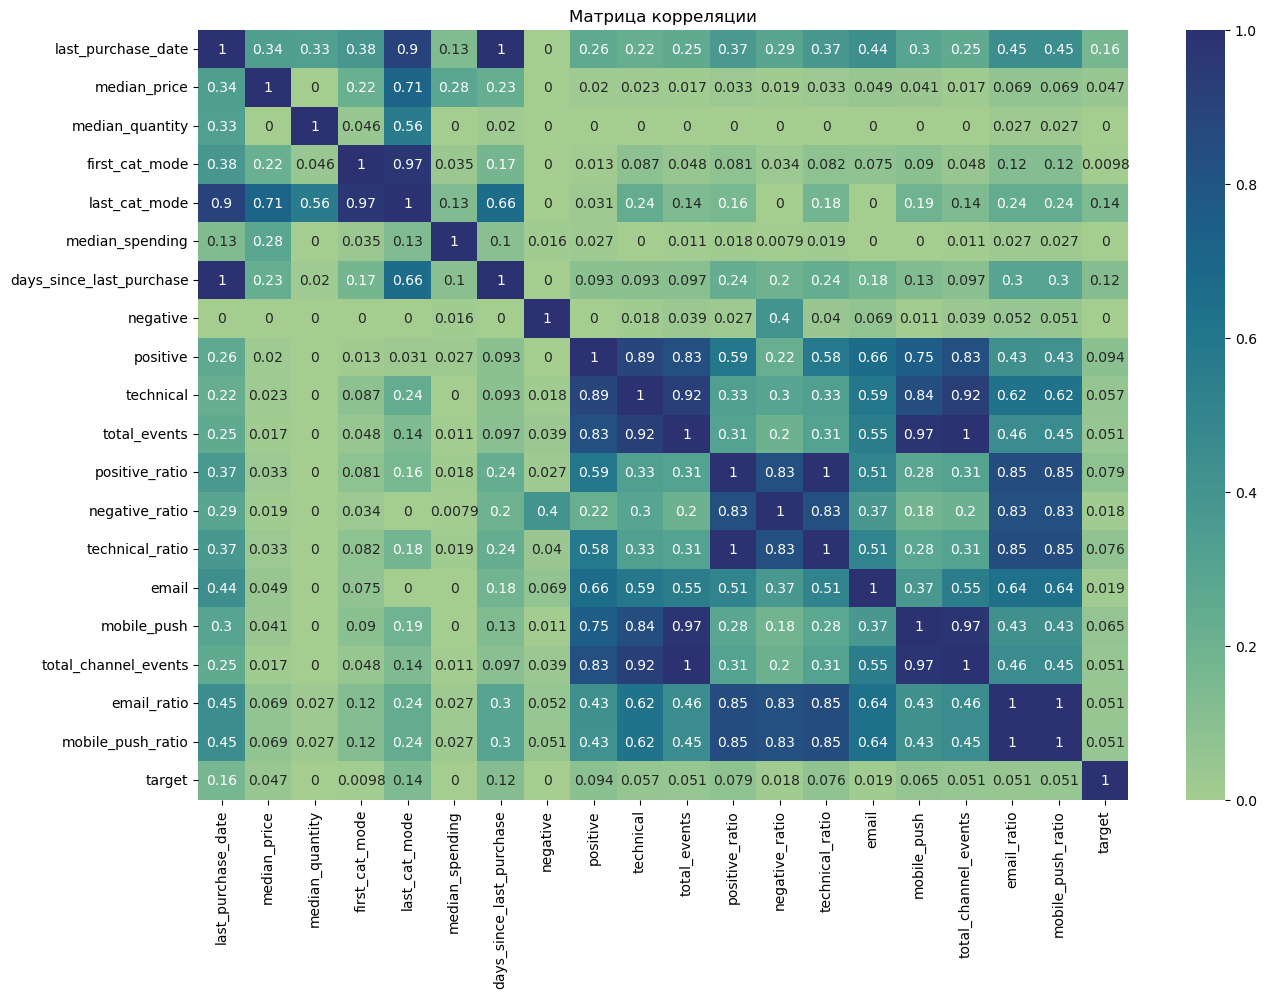

In [65]:
plt.figure(figsize=(15, 10))
sns.heatmap(phik_correlation, annot=True, cmap='crest')
plt.title('Матрица корреляции');

У целевого признака `target` наблюдается достаточно слабая корреляция с остальными признаками. Максимальная корреляция с `positive` (0.094), `positive_ratio` (0.079), `last_purchase_date` (0.16), `days_since_last_purchase` (0.12), `mobile_push` (0.065) и `median_price` (0.047). А самая слабая корреляция с `negative`, `median_quantity`, `median_spending` и `first_cat_mode`.

Можно удалить следующие признаки: 
- `median_quantity`, `median_spending`, `negative`, `technical` - нулевая корреляция с `target`, создают шум
- `email`, `mobile_push`, `total_channel_events` - они дублируются долями (ratio)
- `total_events` - является по сути дубликатом `positive` и `technical`

Оставим `positive_ratio`, `days_since_last_purchase`, `median_price`, `email_ratio`, `first_cat_mode`.

In [66]:
selected_features = [
    'client_id',
    'positive_ratio',
    'days_since_last_purchase',
    'median_price',
    'email_ratio',
    'first_cat_mode',
    'target'
]

df_model = data[selected_features].copy()

## **Выводы по этапу корреляционного анализа данных**

Была построена матрица корреляции, в результате чего наиболее коррелирующими с целевым признаком оказались:  `positive`, `positive_ratio`, `last_purchase_date`, `days_since_last_purchase`, `mobile_push` и `median_price`. 

Для создания модели мы решили оставить следующие признаки: `positive_ratio`, `days_since_last_purchase`, `median_price`, `email_ratio`, `first_cat_mode`.

## **Обучение моделей**

Разделим данные для обучения.

In [67]:
X = df_model.drop(columns=['target', 'client_id'])
y = df_model['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

cv = 3
n_iter = 10

Построим пайплайны.

In [68]:
search_configs = {
    'LogisticRegression': {
        'pipeline': ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('model', LogisticRegression(solver='liblinear', random_state=42))
        ]),
        'params': {
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l1', 'l2']
        }
    },
    'RandomForest': {
        'pipeline': ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
        ]),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    'LightGBM': {
        'pipeline': ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('model', LGBMClassifier(random_state=42, verbose=-1))
        ]),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [-1, 5, 10, 20],
            'model__num_leaves': [15, 31, 63],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__min_child_samples': [10, 20, 50],
            'model__subsample': [0.6, 0.8, 1.0],
            'model__colsample_bytree': [0.6, 0.8, 1.0]
        }
    }
}

Обучим несколько моделей с подбором гиперпараметров через RandomizedSearchCV, вычислим метрику ROC-AUC на валидации и тесте, а затем сохраним результаты и лучшие параметры для сравнения моделей.

In [69]:
results = []

for name, cfg in search_configs.items():
    print(f"Поиск для: {name}")
    
    search = RandomizedSearchCV(
        cfg['pipeline'],
        param_distributions=cfg['params'],
        scoring='roc_auc',
        n_iter=n_iter,
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    # Подавляем предупреждения и обучаем
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        search.fit(X_train, y_train)

    # Лучшая модель
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    test_auc = roc_auc_score(y_test, y_proba)

    print(f"Лучшие параметры для {name}: {search.best_params_}")
    print(f"CV ROC-AUC (во время RandomizedSearch): {search.best_score_:.4f}")
    print(f"Test ROC-AUC: {test_auc:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Дополнительно: оценка на полной выборке через кросс-валидацию
    print(f"Сross_validate для {name} (на всей выборке)...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        val_scores = cross_validate(
            search.best_estimator_,
            X, y,
            cv=cv,
            scoring='roc_auc',
            return_train_score=False,
            n_jobs=-1
        )
    
    val_mean = np.mean(val_scores['test_score'])
    val_std = np.std(val_scores['test_score'])
    
    print(f"Cross-validated ROC-AUC: {val_mean:.4f} ± {val_std:.4f}")
    
    results.append({
        'model': name,
        'cv_auc_search': search.best_score_,
        'val_auc_mean': val_mean,
        'val_auc_std': val_std,
        'test_auc': test_auc,
        'best_params': search.best_params_,
        'best_model': best_model
    })

Поиск для: LogisticRegression
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры для LogisticRegression: {'model__penalty': 'l2', 'model__C': 0.01}
CV ROC-AUC (во время RandomizedSearch): 0.6855
Test ROC-AUC: 0.6942
              precision    recall  f1-score   support

           0       0.99      0.65      0.79      9750
           1       0.03      0.64      0.07       192

    accuracy                           0.65      9942
   macro avg       0.51      0.65      0.43      9942
weighted avg       0.97      0.65      0.77      9942

Сross_validate для LogisticRegression (на всей выборке)...
Cross-validated ROC-AUC: 0.6872 ± 0.0021
Поиск для: RandomForest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры для RandomForest: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 10}
CV ROC-AUC (во время RandomizedSearch): 0.6590
Test ROC-AUC: 0.6996
              precision    r

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/

Лучшие параметры для LightGBM: {'model__subsample': 0.6, 'model__num_leaves': 15, 'model__n_estimators': 200, 'model__min_child_samples': 50, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 1.0}
CV ROC-AUC (во время RandomizedSearch): 0.6837
Test ROC-AUC: 0.7122
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      9750
           1       0.04      0.48      0.08       192

    accuracy                           0.79      9942
   macro avg       0.52      0.64      0.48      9942
weighted avg       0.97      0.79      0.87      9942

Сross_validate для LightGBM (на всей выборке)...
Cross-validated ROC-AUC: 0.6856 ± 0.0071


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [70]:
sorted_results = sorted(results, key=lambda x: x['val_auc_mean'], reverse=True)

# Преобразование в DataFrame с форматированными строками
df_models = pd.DataFrame([{
    "Модель": res['model'],
    "ROC-AUC (валидация)": f"{res['val_auc_mean']:.4f} ± {res['val_auc_std']:.4f}",
    "ROC-AUC (тест)": f"{res['test_auc']:.4f}"
} for res in sorted_results])

df_models

,Модель,ROC-AUC (валидация),ROC-AUC (тест)
0,LogisticRegression,0.6872 ± 0.0021,0.6942
1,LightGBM,0.6856 ± 0.0071,0.7122
2,RandomForest,0.6631 ± 0.0068,0.6996


По результатам теста лучшей моделью стала LightGBM, показавшая максимальное значение ROC-AUC = 0.7122. Logistic Regression показала схожий результат на валидации, но уступила на тестовой выборке. RandomForest оказалась менее стабильной и показала худшие результаты на обеих выборках.

Построим на матрицу ошибок и ROC-кривую.

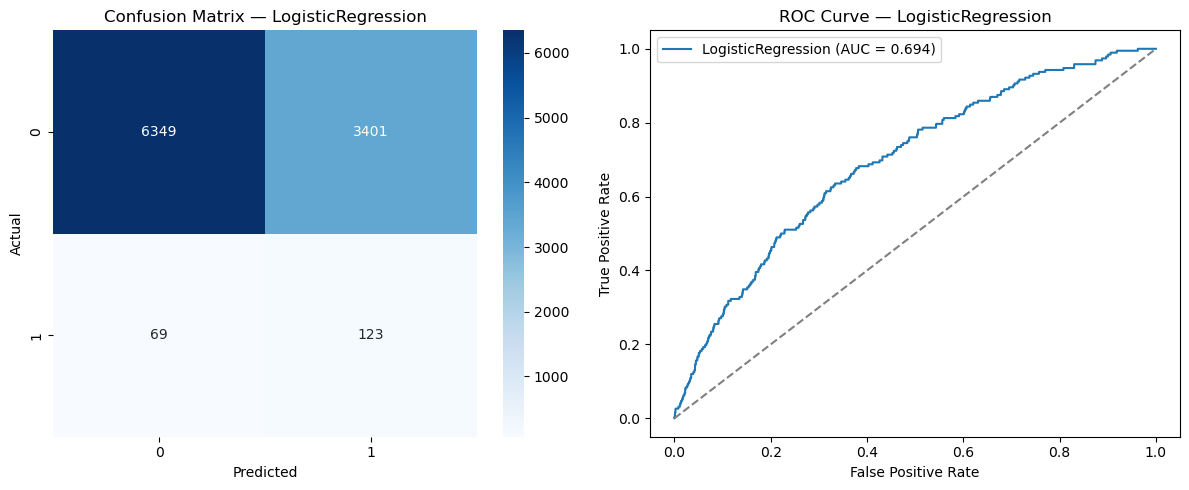

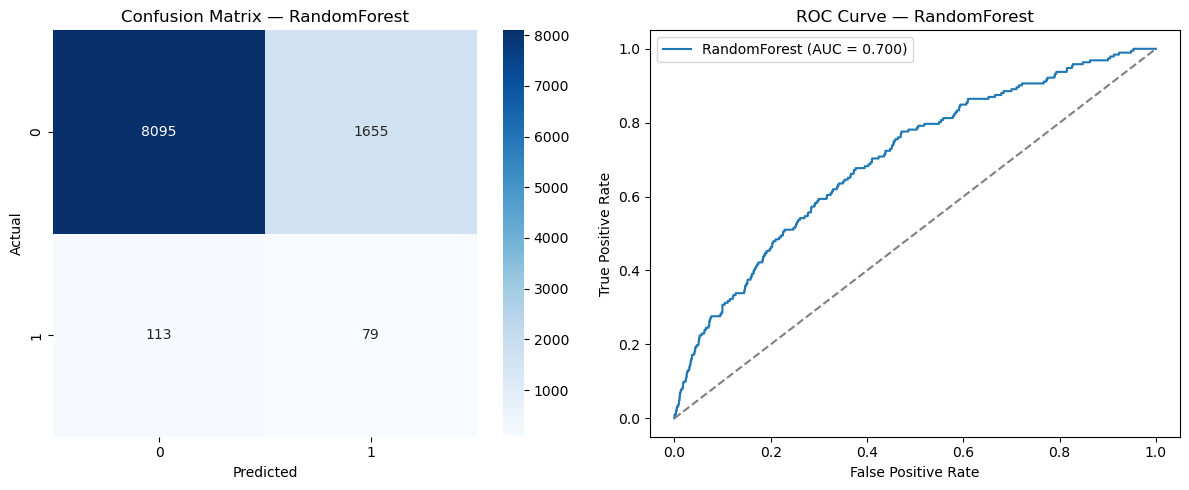

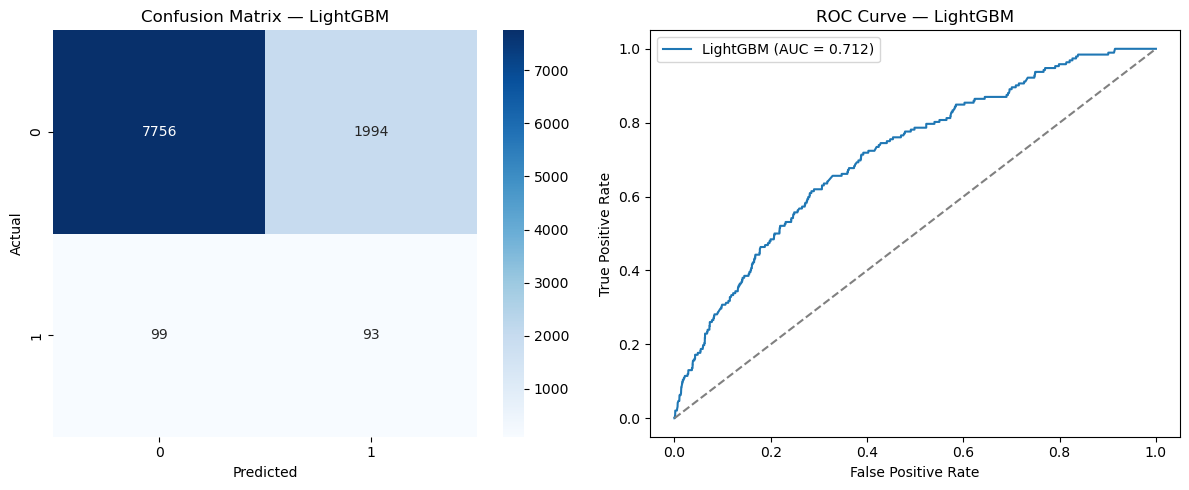

In [71]:
for res in results:
    name = res['model']
    model = res.get('best_model')

    if model is None:
        print(f"Модель {name} не найдена в results — пропущено")
        continue

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix — {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve — {name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

Модель LightGBM обеспечивет наивысшую ROC-AUC и приемлемую классификацию класса 1.

## **Анализ важности признаков**

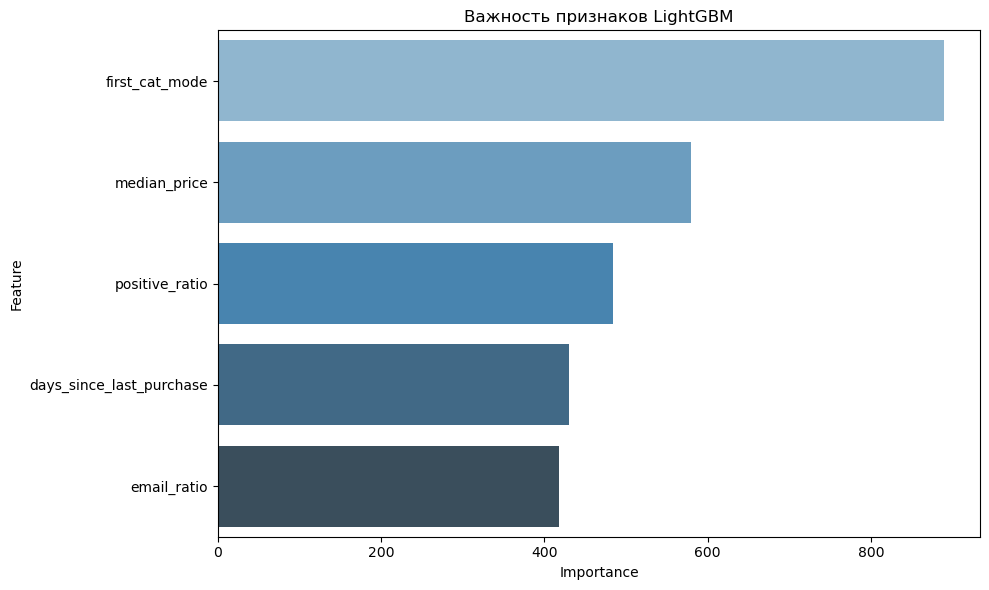

In [72]:
lgbm_final = best_model.named_steps['model']

feature_names = X_train.columns
importances = lgbm_final.feature_importances_

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(), x='Importance', y='Feature', palette='Blues_d')
plt.title(f'Важность признаков LightGBM')
plt.tight_layout()
plt.show()

Анализ важности признаков модели LightGBM показал, что наиболее значимым фактором является `first_cat_mode` Это может свидетельствовать о том, что определённые категории товаров связаны с более высокой вероятностью повторной покупки. Второе место по важности занимает `positive_ratio`. Дальше `median_price` — клиенты с более высокими чеками чаще возвращаются, `email_ratio` - возможно, email стимулирует возврат лучше других каналов рассылки, `days_since_last_purchase` — чем меньше дней прошло, тем выше шанс на новую покупку.

Таким образом, модель использует как поведенческие (вовлечённость, давность действия), так и продуктовые характеристики клиента.

 99%|===================| 9875/9942 [00:12<00:00]        

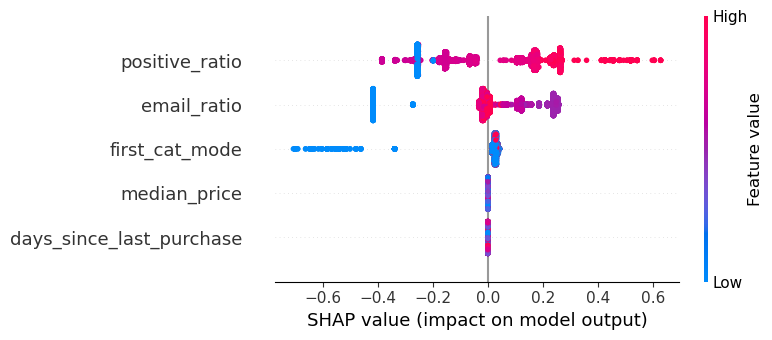

In [73]:
lgbm_final = best_model.named_steps['model']

explainer = shap.Explainer(lgbm_final, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

SHAP-анализ подтверждает важность вовлечённости пользователя (positive_ratio) и актуальности активности (days_since_last_purchase), а также подчёркивает различия в эффективности каналов (email_ratio). 

## **Выводы по этапу машинного обучения**

В ходе обучения разных моделей классификации были протестированы следующие модели: Logistic Regression, Random Forest и LightGBM. По итогам кросс-валидации и тестирования на выборке лучшие результаты показала модель LightGBM со следующими гиперпараметрами:
- `model__num_leaves:` 15,
- `model__n_estimators:` 200,
- `model__max_depth:` 20,
- `model__learning_rate:` 0.01

Метрики качества показали: CV ROC-AUC (RandomizedSearchCV): 0.6836, Test ROC-AUC: 0.7122, Cross-validated ROC-AUC на всей выборке: 0.6857 ± 0.0070.

Модель показывает высокое качество прогноза для отрицательного класса (0), что ожидаемо из-за дисбаланса классов. 

## **Финальный вывод**

В рамках проекта была решена задача классификации клиентов маркетплейса, где целевым признаком выступала вероятность совершения повторной покупки в течение 90 дней. Работа включала все ключевые этапы: загрузку и анализ данных, предобработку, создание новых признаков, исследование, машинное обучение и интерпретацию модели. Были построены и сравнены три модели: Logistic Regression, Random Forest и LightGBM.

**Этап загрузки данных**
`purchases` — 202 208 строк, 6 столбцов. Хранит информацию о заказах. Добавлен признак полной стоимости заказа (price_total).
`messages` — 12 739 798 строк, 7 столбцов. Хранит данные о рассылках, событиях и каналах взаимодействия.
`target` — 49 849 строк, 2 столбца. Целевая переменная — совершение покупки в течение 90 дней.
`event` и `event_ch` — по 131 072 строки. Содержат ежедневную статистику рассылок по событиям и каналам соответственно.

**Этап предобработки данных**
Были удалены дубликаты в `messages`, в `purchases` (36.11%) — оставлены, т.к. могут соответствовать структуре заказа.
Признак `category_ids` преобразован в списки целых чисел. Выделены категории первого (first_cat) и последнего уровней (last_cat).
Ивенты в messages классифицированы на:
- позитивные: open, click, purchase;
- негативные: unsubscribe, hbq_spam, complain, hard_bounce, soft_bounce;
- технические: send, subscribe, close.

**Исследовательский анализ**
Проведён анализ распределений, выявлены и устранены выбросы в price. Установлено, что увеличение количества рассылок не всегда приводит к росту покупок. Обнаружен сильный дисбаланс классов: клиентов, совершивших покупку, значительно меньше (менее 2%).

Построена матрица корреляции (по Phik и Pearson).
Признаки, наиболее коррелирующие с целевым target: positive, positive_ratio, last_purchase_date, days_since_last_purchase, mobile_push, median_price.
Для итоговой модели были отобраны: `positive_ratio`, `days_since_last_purchase`, `median_price`, `email_ratio`, `first_cat_mode`.

**Этап генерации признаков**
Из датафреймов `purchases` и `messages` были сформированы новые признаки с агрегацией по `client_id`. В итоговом датасете data содержатся:
- **Финансовые:** `median_price`, `median_quantity`, `median_spending`, `days_since_last_purchase`
- **Категориальные:** `first_cat_mode`, `last_cat_mode`
- **Ивенты:** `positive`, `negative`, `technical`, `total_events` и соответствующие доли
- **Каналы:** `email`, `mobile_push`, `email_ratio`, `mobile_push_ratio`, `total_channel_events`

После объединения с target в выборке осталось 49 707 уникальных клиентов.

**Основные этапы машинного обучения**
- Проведён отбор признаков: изначально использовались 5 фичей с наибольшей информативностью.
- Проведён баланс классов с помощью SMOTE, так как положительный класс (покупка) был сильно недопредставлен.
- Для каждой модели выполнен подбор гиперпараметров через RandomizedSearchCV с кросс-валидацией по метрике ROC-AUC.
- Выполнена финальная оценка на тестовой выборке и построены матрицы ошибок и ROC-кривые.
- Проведён анализ важности признаков и SHAP-анализ влияния признаков на предсказания модели.

Лучшей моделью стала LightGBM (`num_leaves=15, n_estimators=200, max_depth=20, learning_rate=0.01`). Наилучший результат по метрике ROC-AUC на тестовой выборке: 0.7122. Модели удалось распознать почти половину клиентов, совершивших покупку, сохранив высокую точность по нулевому классу.

Наибольший вклад в предсказания внесли признаки: `first_cat_mode`, `positive_ratio`, `median_price`. Высокие значения `positive_ratio` и `email_ratio` повышают вероятность покупки. Недавняя активность (`days_since_last_purchase`) также положительно влияет на вероятность.

**Рекомендации**
- Использовать предсказания модели для ретаргетинга и персонализированных кампаний
- Провести A/B-тестирование с использованием модели на реальной выборке